In [1]:
## Setting up options to be used during the process
base_state = "Minas Gerais"
#base_state = "Santa Catarina"
compared_state = "São Paulo"
#metric = "confirmed"
#metric = "cases_per_million"
metric = "fatalities_per_million"
states = [base_state, compared_state]

In [2]:
import urllib.request 
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import datetime
import shutil
import imageio

temporary_folder = os.path.join(os.getcwd(), 'tmp')
if os.path.exists(temporary_folder):
    shutil.rmtree(temporary_folder)  
    
if not os.path.exists(temporary_folder):
    os.makedirs(temporary_folder)

In [3]:
## Download and load COVID cases per State in Brazil
covid_cases = pd.read_csv("https://brasil.io/dataset/covid19/caso/?place_type=state&format=csv")
covid_cases = covid_cases.rename({"state": "UF", "date":"last_update"}, axis="columns")

In [4]:
## Load world population DataFrame
population = pd.read_csv("data/brazil_population_per_state_2019.csv")

population = population.rename(
    {"Estado":"state","Population":"population"}, 
    axis='columns') 

In [5]:
## Merge covid and population datasets
covid_cases_pop = pd.merge(covid_cases, population, how='left', on='UF')

In [6]:
## Remove states with no population 
covid_cases_pop['population'] = covid_cases_pop['population'].fillna(0)
covid_cases_pop = covid_cases_pop.loc[covid_cases_pop['population'] != 0]
covid_cases_pop['population'] = covid_cases_pop['population'].astype('int')
covid_cases_pop["last_update"] = pd.to_datetime(covid_cases_pop["last_update"])
covid_cases_pop["last_update"] = covid_cases_pop["last_update"].dt.date

covid_cases_aggr = covid_cases_pop[["state", "last_update", "population", "confirmed", "deaths"]]

In [7]:
## Aggregate by country, date and population
covid_cases_aggr = covid_cases_aggr.groupby(["state", "last_update", "population"]).sum()
covid_cases_aggr = covid_cases_aggr.reset_index()

In [8]:
## Generate forecast for N days (set on days_to_forecast variable) beyond the last data point
## It uses an exponential regresion as a model to forecast
def generate_forecast(states, days_to_forecast, ending_day):

    li = []

    for state in states:
        state_cases = covid_cases_aggr[covid_cases_aggr["state"] == state]
        state_cases = state_cases[state_cases["confirmed"] > 0]
        state_dates = pd.date_range(start=state_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
        state_cases = state_cases.set_index('last_update').reindex(state_dates).fillna(method='pad').rename_axis('last_update').reset_index()
        state_cases = state_cases.reset_index()
        state_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
        if states[0] == state:
            state_cases = state_cases[state_cases["days_since_first_case"] <= ending_day]
        state_cases["type"] = "actuals"
        x = np.array((state_cases["days_since_first_case"]))
        y = np.array((state_cases["confirmed"]))
        confirmed_cases_pred = np.polyfit(x, np.log(y), 1)

        population = int((state_cases["population"]).tail(1))                       
        death_rate = float((state_cases["deaths"].tail(1) * 1.0000) / (state_cases["confirmed"].tail(1) * 1.0000))
        for i in range(1 , state_cases["days_since_first_case"].max() + days_to_forecast - 1):
            confirmed = np.exp(confirmed_cases_pred[1]) * np.exp(confirmed_cases_pred[0] * i) 
            deaths = confirmed * death_rate
            row = {
                "days_since_first_case": i,
                "last_update": (state_cases["last_update"].min() + datetime.timedelta(days=i)),
                "state": state,
                "population": population,
                "confirmed": round(confirmed),
                "deaths": round(deaths),
                "type": "forecast"
            }
            state_cases = state_cases.append(row, ignore_index=True)
        li.append(state_cases)

    covid_cases_final = pd.concat(li, axis=0, ignore_index=True)
    ## Add rate columns
    covid_cases_final["cases_per_million"] = covid_cases_final["confirmed"] / (covid_cases_final["population"] / 1000000)
    covid_cases_final["fatalities_per_million"] = covid_cases_final["deaths"] / (covid_cases_final["population"] / 1000000)
    covid_cases_final["fatalities_per_cases"] = covid_cases_final["deaths"] / covid_cases_final["confirmed"]
    
    return covid_cases_final 

In [9]:
def generate_chart(states, metric, days_to_forecast, ending_day, **kwargs):
    covid_cases_final = generate_forecast(states, days_to_forecast, ending_day)
    
    plt.figure(num=None, figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')
    plt.xlabel('Days Since First Confirmed Case')
    if metric == 'cases_per_million':
        plt.ylabel('Cases Per Million')
    elif metric == "confirmed":
        plt.ylabel('Confirmed Cases')
    elif metric == "fatalities_per_million":
        plt.ylabel('Fatalities Per Million')
        
    if "add_to_title" in kwargs:
        plt.title('COVID-19 Country Curves Comparison' + kwargs["add_to_title"])        
    else:
        covid_cases_state = covid_cases_final[covid_cases_final["state"] == states[0]]
        covid_cases_state = covid_cases_state[covid_cases_state["confirmed"] > 0]
        covid_cases_state = covid_cases_state[covid_cases_state["type"] == "actuals"]
        last_update = (covid_cases_state["last_update"]).max()
        max_days = (covid_cases_state["days_since_first_case"]).max()
        add_to_title = ": " + states[0] + " - Day #" + str(max_days) + " (" + str(last_update)[:10] + ")"
        plt.title('COVID-19 Country Curves Comparison - Base Country' + add_to_title)

    comparing_state_legend = states[0]
    comparing_state = covid_cases_final[covid_cases_final["state"] == comparing_state_legend]
    point_in_time = comparing_state["days_since_first_case"].max()
    green_legend = mpatches.Patch(color='green', label=comparing_state_legend)
    green_legend_forecast = mpatches.Patch(color='cyan', label=comparing_state_legend + " (forecast)", linestyle = ':')
    plt.plot('days_since_first_case', metric, data=comparing_state[comparing_state["type"] == "actuals"], linewidth=3, color="green")
    plt.plot('days_since_first_case', metric, data=comparing_state[comparing_state["type"] == "forecast"], linewidth=3, color="cyan", linestyle = ':')
    x_pos = (comparing_state[comparing_state["type"] == "actuals"])["days_since_first_case"].max()
    y_pos = (comparing_state[(comparing_state["type"] == "actuals")])
    y_pos = (y_pos[y_pos["days_since_first_case"] == x_pos])[metric]
    line_label = (
        "day #" + str(x_pos) + 
        " (" + str((comparing_state[comparing_state["type"] == "actuals"])["last_update"].max())[:10] + ")"
    )
    #plt.text(x_pos, y_pos * 1.1, line_label, ha='right', color="green")
    handles=[green_legend, green_legend_forecast]
    
    if len(states) > 1:
        comparing_state = states[1]
        red_legend = mpatches.Patch(color='red', label=comparing_state)
        comparing_state = covid_cases_final[covid_cases_final["state"] == comparing_state]
        comparing_state = comparing_state[comparing_state["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_state[comparing_state["type"] == "actuals"], linewidth=3, color="red")
        handles.append(red_legend)
        
    if len(states) > 2:
        comparing_country = states[2]
        blue_legend = mpatches.Patch(color='blue', label=comparing_state)
        comparing_state = covid_cases_final[covid_cases_final["state"] == comparing_state]
        comparing_state = comparing_state[comparing_state["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_state[comparing_state["type"] == "actuals"], linewidth=3, color="blue")
        handles.append(blue_legend)
        
    if len(states) > 3:
        comparing_country = states[3]
        black_legend = mpatches.Patch(color='black', label=comparing_state)
        comparing_state = covid_cases_final[covid_cases_final["state"] == comparing_state]
        comparing_state = comparing_state[comparing_state["days_since_first_case"] <= point_in_time]
        plt.plot('days_since_first_case', metric, data=comparing_state[comparing_state["type"] == "actuals"], linewidth=3, color="black")
        handles.append(black_legend)

    if "y_max" in kwargs:
        #print(kwargs["y_max"])
        plt.ylim(top=kwargs["y_max"])
    plt.ylim(bottom=0)
    max_x_axis, max_y_axis = plt.ylim()
    plt.legend(handles=handles)
    plt.text(0, (max_y_axis / 7 * -1), "Source: ESPECIAL COVID-19 - Dados por Município (https://brasil.io/covid19/)", ha='left')
    if "save_chart" in kwargs:
        if kwargs["save_chart"] == True:
            plt.savefig(kwargs["file_name"], dpi=100, format='png', bbox_inches='tight')
            plt.close()
            #print(kwargs["file_name"])
        
    #plt.show()

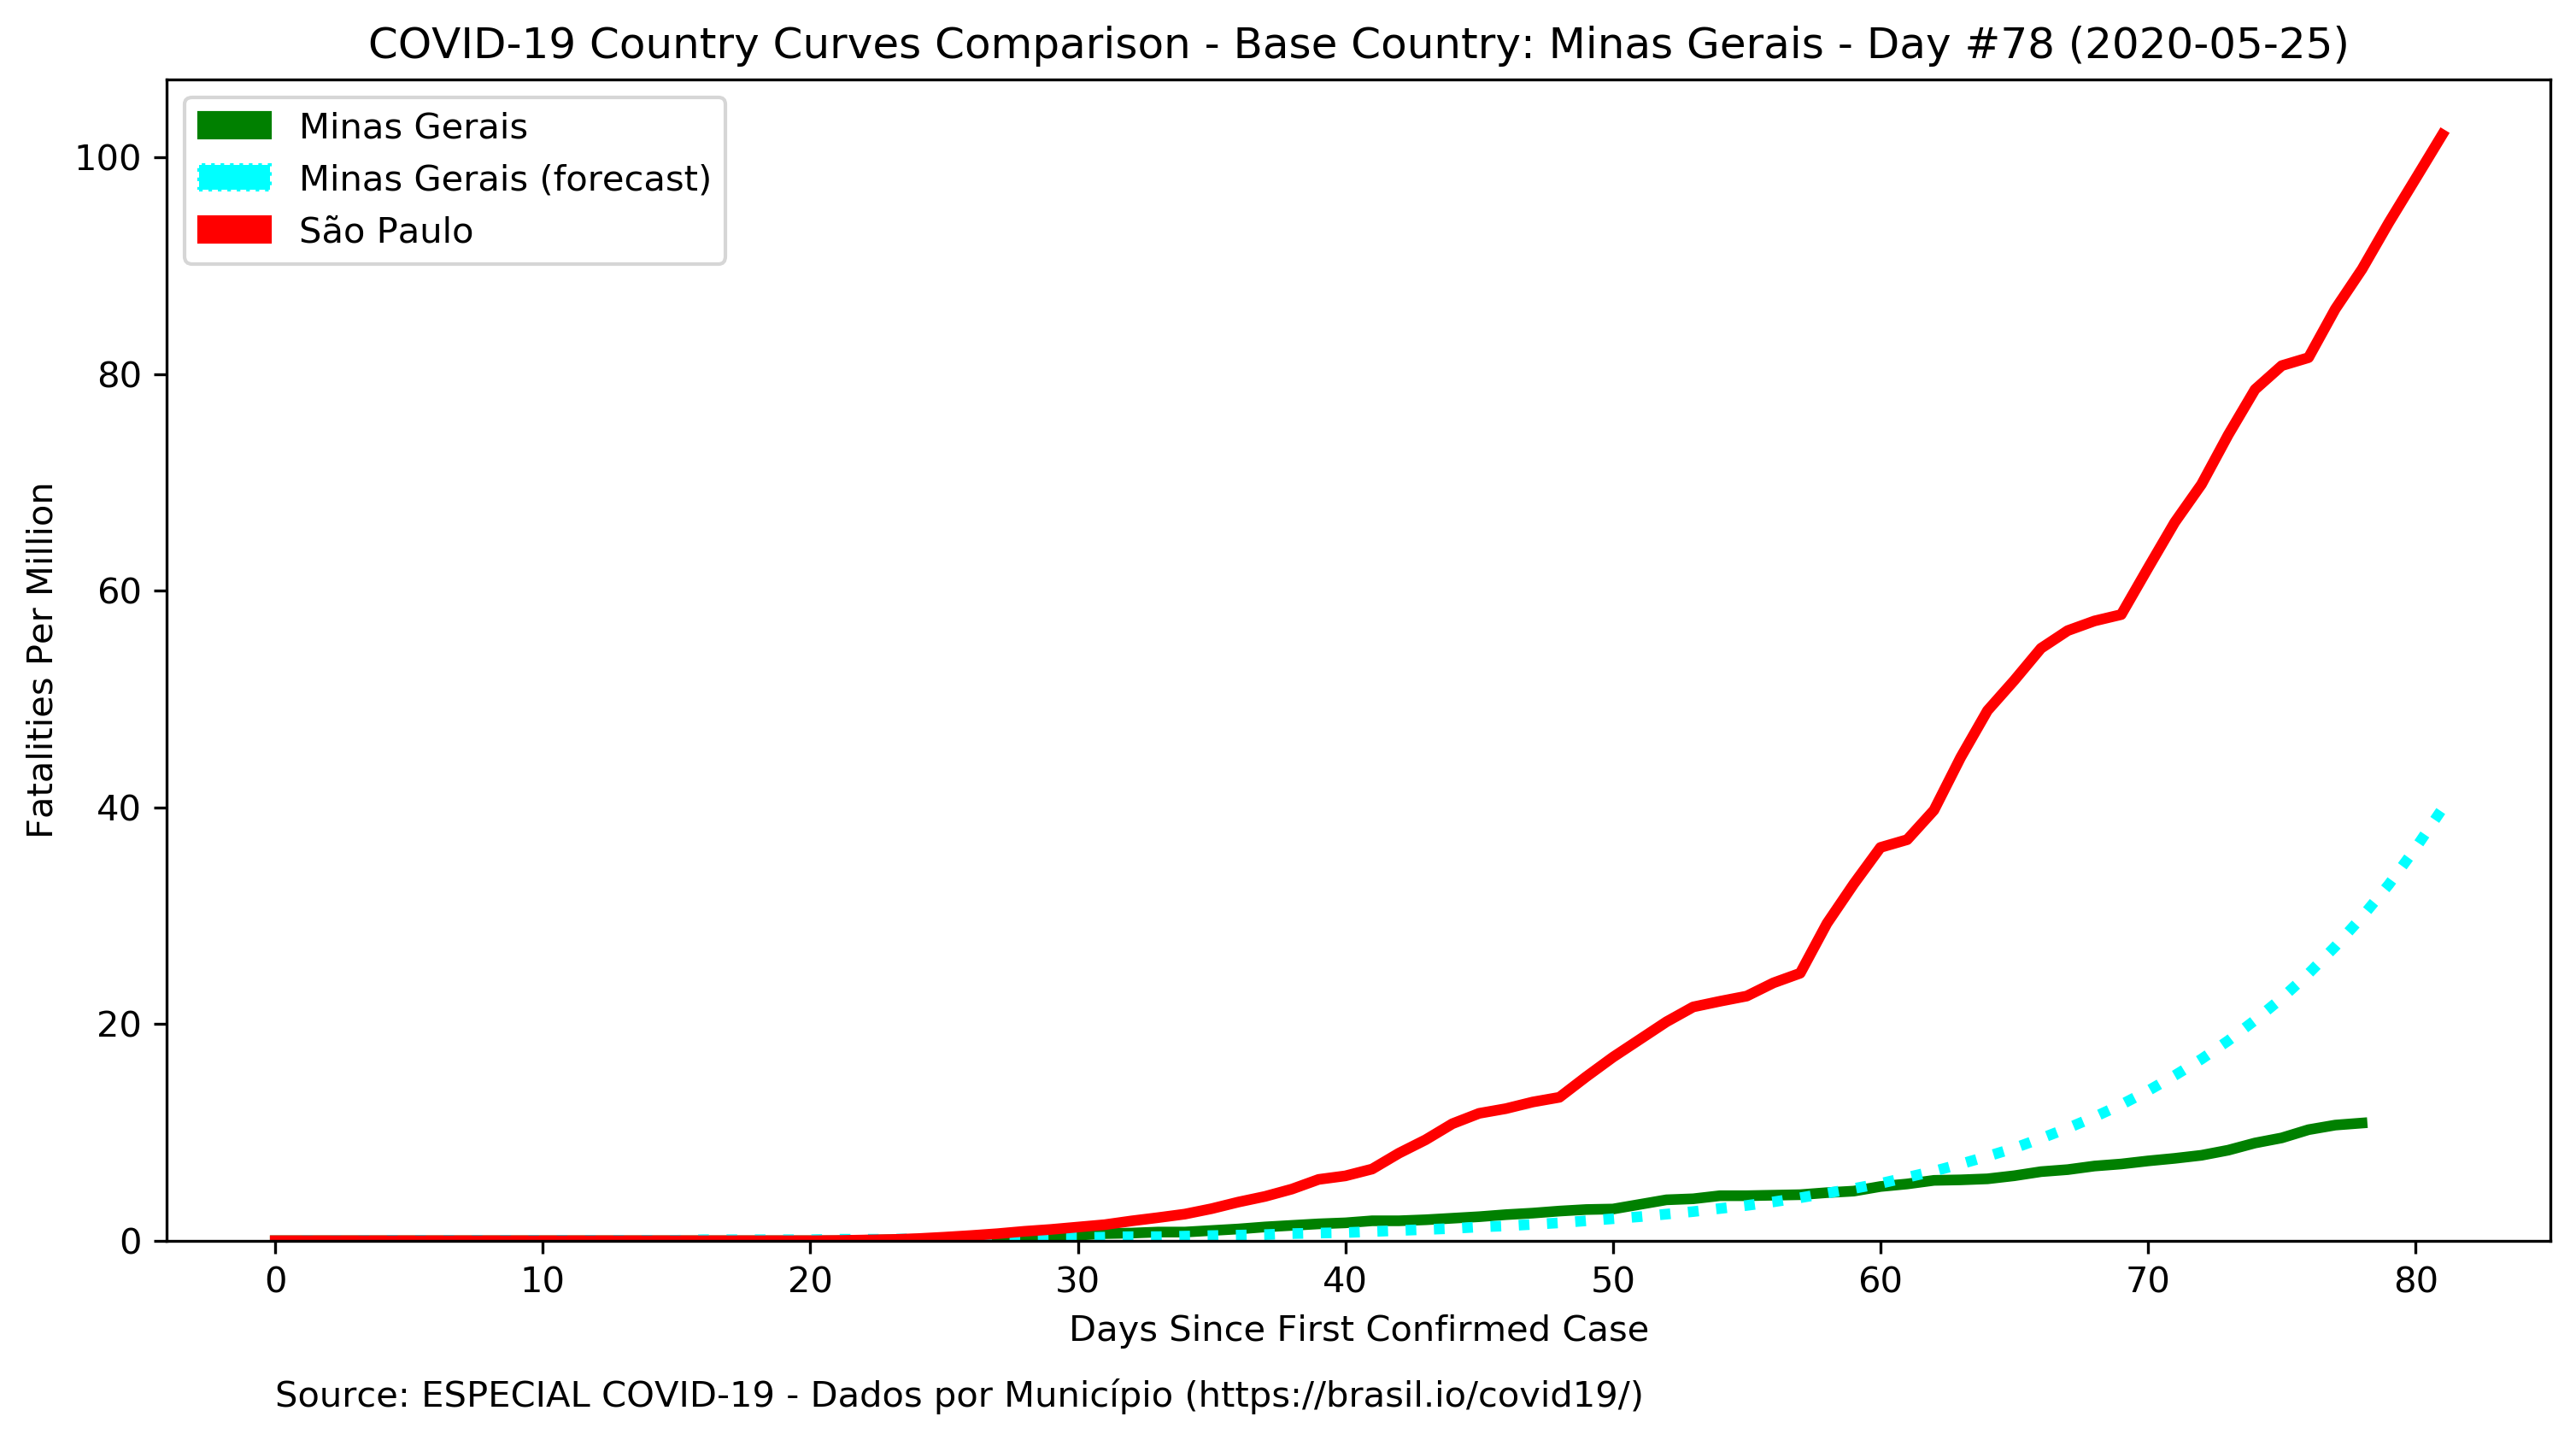

In [10]:
generate_chart(states=states, metric=metric, days_to_forecast=5, ending_day=1000)

In [11]:
def generate_animation(state_base, state_compared, metric):

    img_folder = os.path.join(os.getcwd(), 'img') 
    if os.path.exists(img_folder):
        shutil.rmtree(img_folder)  
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    covid_cases_state = covid_cases_aggr[covid_cases_aggr["state"] == state_base]
    covid_cases_state = covid_cases_state[covid_cases_state["confirmed"] > 0]
    first_case = (covid_cases_state["last_update"]).min()
    last_update = (covid_cases_state["last_update"]).max()
    max_days = (last_update - first_case).days

    covid_cases_state = covid_cases_aggr[covid_cases_aggr["state"] == state_compared]
    covid_cases_state = covid_cases_state[covid_cases_state["last_update"] == (covid_cases_state["last_update"]).max()]
    covid_cases_state["cases_per_million"] = covid_cases_state["confirmed"] / (covid_cases_state["population"] / 1000000)
    covid_cases_state["fatalities_per_million"] = covid_cases_state["deaths"] / (covid_cases_state["population"] / 1000000)
    covid_cases_state["fatalities_per_cases"] = covid_cases_state["deaths"] / covid_cases_state["confirmed"]

    y_max = int(covid_cases_state[metric] * 1.05)

    for i in range(10 , max_days + 1):
        processing_date = first_case + datetime.timedelta(days=i) 
        add_to_title = ": " + state_base + " - Day #" + str(i) + " (" + str(processing_date) + ")"
        file_name = os.path.join(img_folder, (str(i) + ".png"))
        generate_chart(
            states=[state_base, state_compared], 
            metric=metric, 
            days_to_forecast=10, 
            ending_day=i, 
            save_chart = True, 
            file_name=file_name, 
            add_to_title=add_to_title
        )



    animation_folder = os.path.join(os.getcwd(), 'animation') 
    if not os.path.exists(animation_folder):
        os.makedirs(animation_folder)

    images = []
    for filename in sorted(os.listdir(img_folder)):
        file_path = os.path.join(img_folder, filename)
        images.append(imageio.imread(file_path))
    output_file = state_base + "_vs_" + state_compared + "_" + metric + ".gif"
    output_file = os.path.join(animation_folder, output_file)
    print(output_file)
    imageio.mimsave(output_file, images, duration=1)

In [12]:
generate_animation(state_base = base_state, state_compared = compared_state, metric = metric)

/Users/wcunha69/Documents/projects/COVID-19/animation/Minas Gerais_vs_São Paulo_fatalities_per_million.gif


In [13]:
def generate_chart_days_to_double(states, metric):
    metric_previous = metric + "_previous"
    metric_to_double = metric + "_days_to_double"
    
    li = []

    start_day = None
    end_day = None 

    for state in states:
        state_cases = covid_cases_aggr[covid_cases_aggr["state"] == state]
        state_cases = state_cases[state_cases["confirmed"] > 0]
        state_dates = pd.date_range(start=state_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
        state_cases = state_cases.set_index('last_update').reindex(state_dates).fillna(method='pad').rename_axis('last_update').reset_index()
        state_cases = state_cases.reset_index()
        state_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
        state_cases_before = state_cases[["days_since_first_case", "confirmed", "deaths"]]
        state_cases_before = state_cases_before.rename({"confirmed":"confirmed_previous", "deaths":"deaths_previous"}, axis="columns")
        state_cases_before["days_since_first_case"] = (state_cases_before["days_since_first_case"] + 1)

        state_cases = pd.merge(state_cases, state_cases_before, how='left', on='days_since_first_case')
        state_cases[metric_to_double] = round((state_cases[metric]) / (state_cases[metric] - state_cases[metric_previous]), 1)
        if state == states[0]:
            state_slice = state_cases.tail(10)
            start_day = state_slice.days_since_first_case.min()
            end_day = state_slice.days_since_first_case.max()
            #print(start_day, end_day)

        state_cases = state_cases[state_cases["days_since_first_case"] >= start_day]
        state_cases = state_cases[state_cases["days_since_first_case"] <= end_day]

        li.append(state_cases)

    covid_cases_final = pd.concat(li, axis=0, ignore_index=True)
    covid_cases_final
    #state_cases_before


    plt.figure(num=None, figsize=(12, 6), dpi=300, facecolor='w', edgecolor='k')

    ind = np.arange(len(covid_cases_final[covid_cases_final["state"] == states[0]])) 
    width = 0.35
    group_a = (covid_cases_final[covid_cases_final["state"] == states[0]])
    plt.bar(ind, group_a[metric_to_double], width, label=states[0])
    for index, each in group_a.iterrows():
        plt.text((index + width / 2) - (width / 2), each[metric_to_double], each[metric_to_double], 
                 fontsize=9, horizontalalignment='center', verticalalignment='center', color="black")

    group_b = (covid_cases_final[covid_cases_final["state"] == states[1]])
    plt.bar(ind + width, group_b[metric_to_double], width, label=states[1])
    for index, each in group_b.iterrows():
        plt.text(((index - 10) + width / 2) + (width / 2), each[metric_to_double], each[metric_to_double], 
                 fontsize=9, horizontalalignment='center', verticalalignment='center', color="black")

    plt.ylabel('Doubling in X days')
    plt.title('Days to Double - ' + metric)

    plt.xticks(ind + width / 2, (covid_cases_final[covid_cases_final["state"] == states[0]])["days_since_first_case"])
    plt.legend(loc='best')
    plt.show()

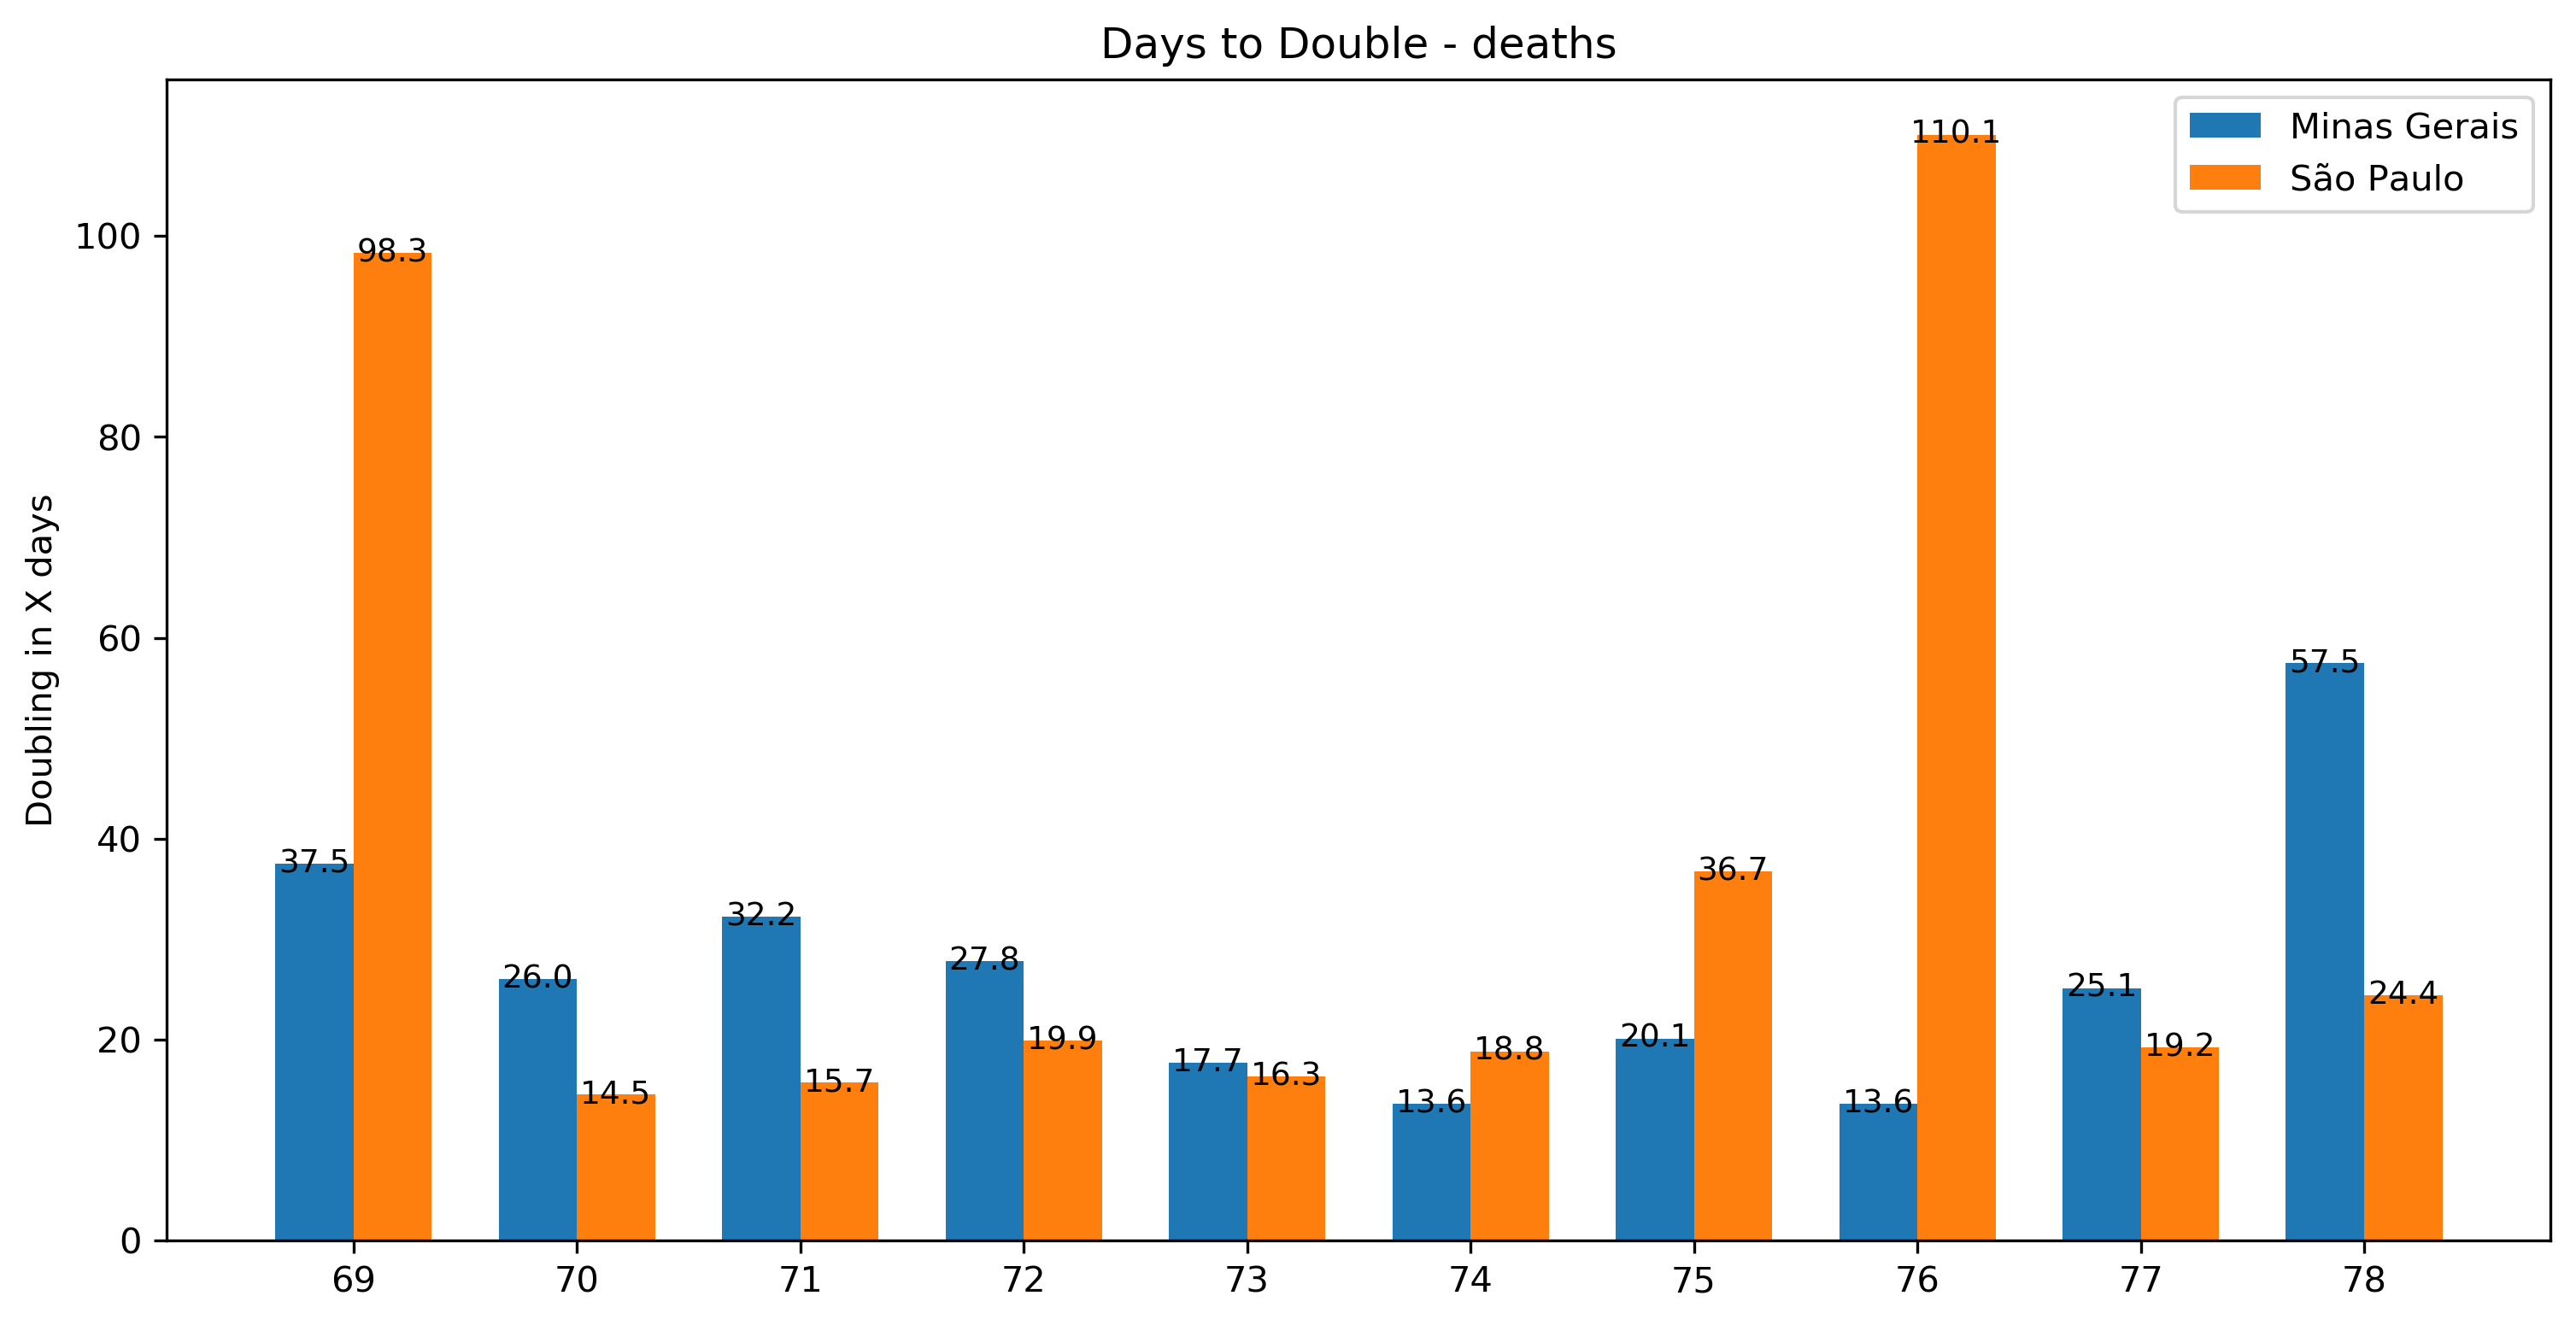

In [14]:
generate_chart_days_to_double(states, "deaths")

In [15]:

state_comparison = []
for state in states:
    state_cases = covid_cases_aggr[covid_cases_aggr["state"] == state]
    state_cases = state_cases[state_cases["confirmed"] > 0]
    state_dates = pd.date_range(start=state_cases.last_update.min(), end=covid_cases_aggr.last_update.max())
    state_cases = state_cases.set_index('last_update').reindex(state_dates).fillna(method='pad').rename_axis('last_update').reset_index()
   
    #state_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
    state_cases["cases_per_million"] = state_cases["confirmed"] / (state_cases["population"] / 1000000)
    state_cases["fatalities_per_million"] = state_cases["deaths"] / (state_cases["population"] / 1000000)
    state_cases["fatalities_per_cases"] = state_cases["deaths"] / state_cases["confirmed"]
    state_cases = state_cases[["last_update", "confirmed", "deaths", "cases_per_million", "fatalities_per_million", "fatalities_per_cases"]]
    state_cases = state_cases.add_prefix(state.replace(" ", " ").lower() + "_")
    state_cases = state_cases.reset_index()
    state_cases.rename(columns = {'index':'days_since_first_case'}, inplace = True) 
    if state == states[0]:
        state_comparison = state_cases
    else:
        state_comparison = pd.merge(state_comparison, state_cases, left_on='days_since_first_case', right_on='days_since_first_case', how="outer")

ext_folder = os.path.join(os.getcwd(), 'extractions') 
if os.path.exists(ext_folder):
    shutil.rmtree(ext_folder)  
if not os.path.exists(ext_folder):
    os.makedirs(ext_folder)
file_name = os.path.join(ext_folder, "states_comparison.csv")
state_comparison.to_csv(file_name)
state_comparison




,days_since_first_case,minas gerais_last_update,minas gerais_confirmed,minas gerais_deaths,minas gerais_cases_per_million,minas gerais_fatalities_per_million,minas gerais_fatalities_per_cases,são paulo_last_update,são paulo_confirmed,são paulo_deaths,são paulo_cases_per_million,são paulo_fatalities_per_million,são paulo_fatalities_per_cases
0,0,2020-03-08,1.0,0.0,0.047239,0.0,0.0,2020-02-25,1.0,0.0,0.021777,0.000000,0.000000
1,1,2020-03-09,1.0,0.0,0.047239,0.0,0.0,2020-02-26,1.0,0.0,0.021777,0.000000,0.000000
2,2,2020-03-10,1.0,0.0,0.047239,0.0,0.0,2020-02-27,1.0,0.0,0.021777,0.000000,0.000000
3,3,2020-03-11,1.0,0.0,0.047239,0.0,0.0,2020-02-28,2.0,0.0,0.043555,0.000000,0.000000
4,4,2020-03-12,2.0,0.0,0.094479,0.0,0.0,2020-02-29,2.0,0.0,0.043555,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,NaT,NaN,NaN,NaN,NaN,NaN,2020-05-21,73739.0,5558.0,1605.847717,121.039092,0.075374
87,87,NaT,NaN,NaN,NaN,NaN,NaN,2020-05-22,76871.0,5773.0,1674.054704,125.721245,0.075100
88,88,NaT,NaN,NaN,NaN,NaN,NaN,2020-05-23,80558.0,6045.0,1754.348179,131.644712,0.075039
89,89,NaT,NaN,NaN,NaN,NaN,NaN,2020-05-24,82161.0,6163.0,1789.257439,134.214452,0.075011
